In [1]:
import cv2
import sqlite3 
import json
import pickle
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [ ]:
# load json
json_path = '../outputs/yolo_detections_all_videos.json'
with open(json_path, 'r') as f:
    yolo_detections = json.load(f)
    
images = yolo_detections['images']<

## Visualize Yolo Output

In [2]:
# Extract a specific frame from a video
def get_frame(
    video_path = str, 
    frame_number = int):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Frame number {frame_number} could not be retrieved.")
    return frame
    
def display_yolo_detections(frame_id = str):
    base_filename = frame_id.rsplit('_', 1)[0]
    video_name = f"{base_filename}.MP4"
    video_path = '../../../ProcessedData/videos/' + video_name
    frame_int = int(frame_id.split('_')[-1])
    frame = get_frame(video_path, frame_int)
    # Convert frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    
    # Get detections for the frame
    detections = [image['annotations'] for image in images if image['image_id'] == f'{frame_id}.jpg']

    # Check if detections list is empty or if the first element is empty
    if len(detections) == 0 or len(detections[0]) == 0:
        print(f'No detections found for {frame_id}.jpg')
        # Convert frame back to RGB for display
        plt.figure(figsize=(20, 16))
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.show()
        return
    
    for detection in detections[0]:
        cls = detection['class']
        bbox = detection['bbox']
        confidence = detection['confidence']
        
        x_center, y_center, width, height = bbox
        # Convert normalized coordinates to pixel values
        x1 = int((x_center - width / 2) * frame_width)
        y1 = int((y_center - height / 2) * frame_height)
        x2 = int((x_center + width / 2) * frame_width)
        y2 = int((y_center + height / 2) * frame_height)
    
        # Draw bounding boxes on the frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 139), 5)
        
        label = f"person: {confidence:.2f}"
        print(label)
        cv2.putText(frame, label, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 139), 5)
        
    # Convert frame back to RGB for display
    plt.figure(figsize=(20, 16))
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_frame)
    plt.axis('off')
    plt.show()

person: 0.66
person: 0.59
person: 0.55
person: 0.36
person: 0.32
person: 0.29
person: 0.28


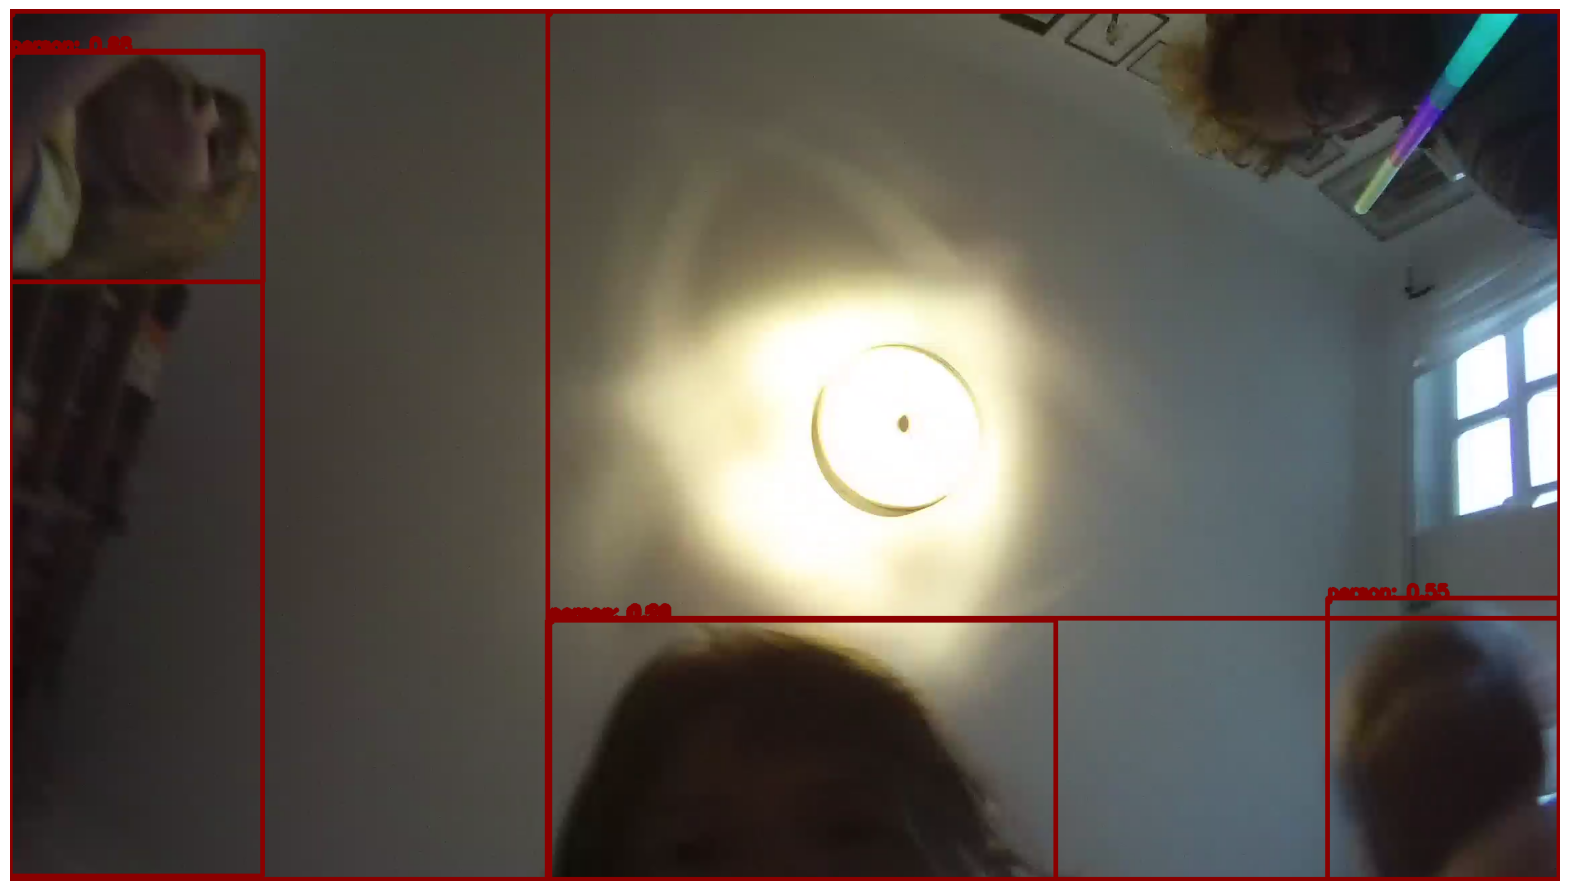

In [7]:
display_yolo_detections('quantex_at_home_id271700_2023_06_08_01_000960')

## Count frequency of person detections

In [3]:
# load json
json_path = '../outputs/yolo_detections_train_videos_035.json'
with open(json_path, 'r') as f:
    yolo_detections_train = json.load(f)
    
images = yolo_detections_train['images']

# Initialize counters
total_images = len(images)
detection_counts = {}  # Dictionary to hold counts of images with 0, 1, 2, ... detections

# Iterate through the data
for image_data in images:
    # Count the number of detections for the current image
    num_detections = len(image_data['annotations'])
    image_id = image_data['image_id']
    
    # Update the detection counts dictionary
    if num_detections in detection_counts:
        detection_counts[num_detections]['count'] += 1
        detection_counts[num_detections]['image_ids'].append(image_id)
    else:
        detection_counts[num_detections] = {'count': 1, 'image_ids': [image_id]}

# Display the results
print(f"Total number of images: {total_images}")
for num_detections, data in sorted(detection_counts.items()):
    count = data['count']
    percentage = (count / total_images) * 100
    if num_detections <= 1:
        print(f"Images with {num_detections} person detected: {count} ({percentage:.2f}%)")
    else:
        print(f"Images with {num_detections} persons detected: {count} ({percentage:.2f}%)")

Total number of images: 140200
Images with 0 person detected: 88234 (62.93%)
Images with 1 person detected: 40870 (29.15%)
Images with 2 persons detected: 9344 (6.66%)
Images with 3 persons detected: 1574 (1.12%)
Images with 4 persons detected: 169 (0.12%)
Images with 5 persons detected: 8 (0.01%)
Images with 6 persons detected: 1 (0.00%)


## Determine best IOU parameter configuration

In [4]:
# load detections for train videos 04
json_path = '../outputs/yolo_detections_train_videos_035.json'
with open(json_path, 'r') as f:
    yolo_detections_train = json.load(f)
    
images_train_four = yolo_detections_train['images']

# Initialize dictionary to hold counts of detections per image
detection_counts_train = {}  

# Iterate through the data
for image_data in images_train_four:
    # Extract image_id and count the number of detections for the current image
    image_id = image_data['image_id']
    num_detections = len(image_data['annotations'])
    
    # Update the detection counts dictionary with image_id as the key
    detection_counts_train[image_id] = num_detections


In [5]:
len(detection_counts_train)

140200

In [6]:
conn = sqlite3.connect('../../../ProcessedData/databases/annotations.db')

def fetch_ground_truth_labels(frame_id):
    """
    Fetches the ground truth labels from the database for a given frame ID.
    
    Args:
        frame_id (str): The frame ID from which to fetch ground truth labels.
    
    Returns:
        int or None: Returns the count of persons if found, otherwise None.
    """
    # Split into base name and frame number
    parts = frame_id.rsplit('_', 1)  # Split at the last underscore
    video_name = parts[0] + ".mp4"  # Append .mp4 to the base name
    frame_number = parts[1].lstrip('0')  # Remove leading zeros from the frame number
    
    query = """
    SELECT COUNT(*) AS person_count
    FROM annotations a
    JOIN videos v ON a.video_id = v.id
    WHERE a.category_id = 1 
      AND a.outside = 0 
      AND a.image_id = ? 
      AND v.file_name = ?
    """
    cursor = conn.execute(query, (frame_number, video_name))
    result = cursor.fetchone()
    return result[0] if result and result[0] is not None else None

# Update the dictionary with tuples (count, function_count)
keys_to_delete = []  # To store keys that need to be deleted
        
for key in detection_counts_train:
    # Remove the .jpg extension from the key
    base_name = key.rsplit('.jpg', 1)[0]
    # Get the function result
    function_count = fetch_ground_truth_labels(base_name)
    # Update the dictionary entry
    if function_count is None:
        # Mark the entry for deletion if no ground truth is found
        keys_to_delete.append(key)
    else:
        # Update the entry with a tuple (existing count, function count)
        existing_count = detection_counts_train[key]
        detection_counts_train[key] = (existing_count, function_count)

# Remove entries that have None values
for key in keys_to_delete:
    del detection_counts_train[key]
    
with open('detection_labels_comparison_035.pkl', 'wb') as f:
    pickle.dump(detection_counts_train, f)
# Print the updated dictionary
print(len(detection_counts_train))

In [14]:
with open('detection_labels_comparison_04.pkl', 'rb') as f:
    detection_counts_train_04 = pickle.load(f)
with open('detection_labels_comparison_035.pkl', 'rb') as f:
    detection_counts_train_035 = pickle.load(f)
with open('detection_labels_comparison_045.pkl', 'rb') as f:
    detection_counts_train_045 = pickle.load(f)
    
def compare_detections_with_ground_truth(detected_count, true_count):
    """
    Compare YOLO detections with ground truth annotations.
    """
    return detected_count == true_count

# Initialize counters for each threshold
matches_035 = 0
matches_040 = 0
matches_045 = 0
mismatches_035 = 0
mismatches_040 = 0
mismatches_045 = 0
# Process each YOLO result for threshold 0.35
for frame_name, (detected_count_035, true_count_035) in detection_counts_train_035.items():
    if compare_detections_with_ground_truth(detected_count_035, true_count_035):
        matches_035 += 1
    else:
        mismatches_035 += 1

# Process each YOLO result for threshold 0.4
for frame_name, (detected_count_040, true_count_040) in detection_counts_train_04.items():
    if compare_detections_with_ground_truth(detected_count_040, true_count_040):
        matches_040 += 1
    else:
        mismatches_040 += 1
        
# Process each YOLO result for threshold 0.45
for frame_name, (detected_count_045, true_count_045) in detection_counts_train_045.items():
    if compare_detections_with_ground_truth(detected_count_045, true_count_045):
        matches_045 += 1
    else:
        mismatches_045 += 1
# Print the results
print(f"Threshold 0.35 - Matches: {matches_035}, Mismatches: {mismatches_035}")
print(f"Threshold 0.4  - Matches: {matches_040}, Mismatches: {mismatches_040}")
print(f"Threshold 0.45  - Matches: {matches_045}, Mismatches: {mismatches_045}")


Video Name: quantex_at_home_id257511_2021_07_12_01.mp4
Frame Number: 3720


2

## Proximity Heuristic

In [9]:
model = YOLO('../../../models/yolov8_trained.pt')

def calculate_proximity_score(width, height, img_width, img_height):
    """
    Calculate proximity score for a single detected person based on bounding box size.
    
    Args:
    - detection (dict): A dictionary with keys 'x', 'y', 'width', 'height' representing the bounding box.
    - img_width (int): Width of the image.
    - img_height (int): Height of the image.
    
    Returns:
    - proximity_score (float): Proximity score for the detection.
    """    
    # Calculate the area of the bounding box
    bbox_area = width * height
    
    # Normalize the area by the image size to make it relative
    normalized_area = bbox_area / (img_width * img_height)
    
    # Calculate the proximity score (higher area means closer, so we use inverse)
    proximity_score = 1 / (normalized_area + 1e-6)  # Adding a small epsilon to avoid division by zero
    
    return proximity_score

def get_proximity_segment(proximity_score):
    """
    Categorize the proximity score into segments.
    
    Args:
    - proximity_score (float): The proximity score calculated for a detected person.
    
    Returns:
    - segment (str): The segment the proximity score falls into.
    """
    if proximity_score > 100:
        return "Very Close"
    elif proximity_score > 50:
        return "Close"
    elif proximity_score > 20:
        return "Medium Distance"
    elif proximity_score > 10:
        return "Far"
    else:
        return "Very Far"


def display_yolo_detections_with_proximity(frame_id = str):
    base_filename = frame_id.rsplit('_', 1)[0]
    video_name = f"{base_filename}.MP4"
    video_path = '../../../ProcessedData/videos/' + video_name
    frame_int = int(frame_id.split('_')[-1])
    frame = get_frame(video_path, frame_int)
    # Convert frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    
    # Get detections for the frame
    detections = model(frame, iou=0.4)
    #TODO: iou=0.4 or or 0.35

    # Check if detections list is empty or if the first element is empty
    if len(detections[0]) == 0 or len(detections[0].boxes) == 0:
        print(f'No detections found for {frame_id}.jpg')
        # Convert frame back to RGB for display
        plt.figure(figsize=(20, 16))
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.show()
        return
    
    # Add the annotations for the detected objects
    for boxes in detections[0].boxes:
        # Get the bounding box coordinates (x center, y center, width, height) normalized to the image size
        x_center, y_center, width, height = boxes.xywhn[0]
        confidence = boxes.conf[0]
        # Get the category ID and name
        # Convert normalized coordinates to pixel values
        x1 = int((x_center - width / 2) * frame_width)
        y1 = int((y_center - height / 2) * frame_height)
        x2 = int((x_center + width / 2) * frame_width)
        y2 = int((y_center + height / 2) * frame_height)
    
        # Draw bounding boxes on the frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 139), 5)
        
        label = f"person: {confidence:.2f}"
        proximity_score = calculate_proximity_score(width, height, frame_width, frame_height)
        proximity_segment = get_proximity_segment(proximity_score)
        print(f"{label} - Proximity score: {proximity_score}, Segment: {proximity_segment}")
        cv2.putText(frame, f"{label} - {proximity_score}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 139), 5)
        
    # Convert frame back to RGB for display
    plt.figure(figsize=(20, 16))
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_frame)
    plt.axis('off')
    plt.show()


In [27]:
images[1200]

{'image_id': 'quantex_at_home_id254922_2022_04_19_01_000810.jpg',
 'annotations': [{'class': 'person',
   'bbox': [0.7675827145576477,
    0.6898499727249146,
    0.292000412940979,
    0.6200712323188782],
   'confidence': 0.7295878529548645},
  {'class': 'person',
   'bbox': [0.010500325821340084,
    0.656741201877594,
    0.020987296476960182,
    0.29673314094543457],
   'confidence': 0.297862708568573}]}


0: 384x640 (no detections), 22.4ms
Speed: 4.2ms preprocess, 22.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
No detections found for quantex_at_home_id255237_2022_05_08_02_025740.jpg


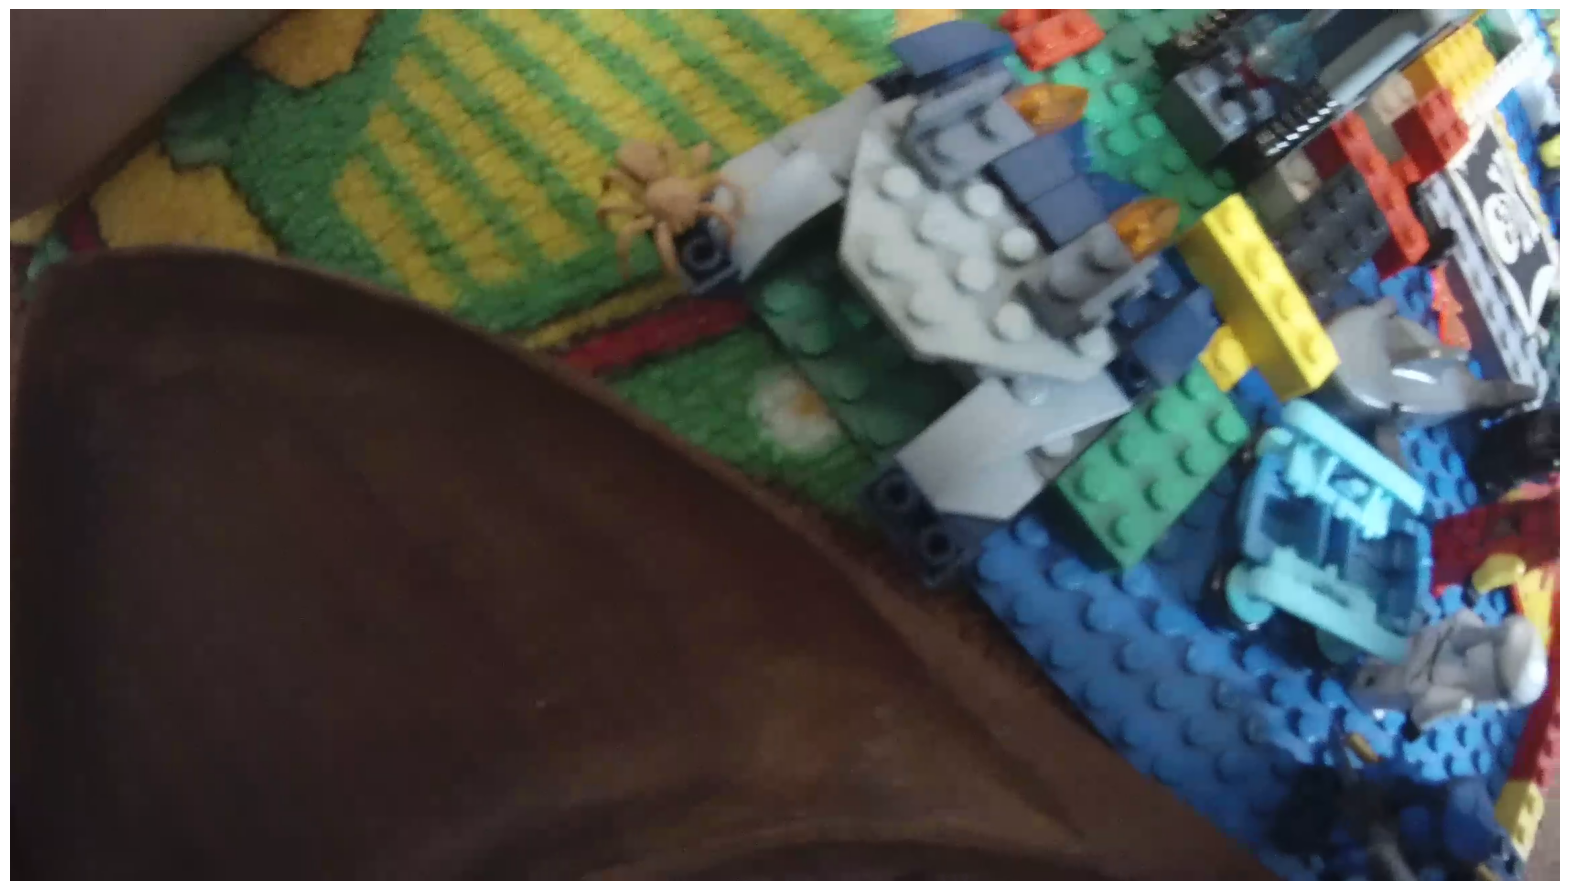

In [11]:
display_yolo_detections_with_proximity('quantex_at_home_id255237_2022_05_08_02_025740')

## Optical Flow and Motion Parallax 

import cv2
import numpy as np
from ultralytics import YOLO

# Load YOLO model
model = YOLO('../../../models/yolov8_trained.pt')

def get_initial_detections(frame):
    """
    Perform initial detections on the first frame using YOLO model.
    
    Args:
    - frame (ndarray): The initial frame from the video.
    
    Returns:
    - detections (list): List of detected bounding boxes and corresponding points to track.
    """
    detections = model(frame, iou=0.4)
    initial_points = []

    if len(detections[0].boxes) > 0:
        for boxes in detections[0].boxes:
            x_center, y_center, width_norm, height_norm = boxes.xywhn[0]
            confidence = boxes.conf[0]

            # Convert normalized coordinates to pixel values
            frame_height, frame_width = frame.shape[:2]
            x_center_pixel = int(x_center * frame_width)
            y_center_pixel = int(y_center * frame_height)
            width_pixel = int(width_norm * frame_width)
            height_pixel = int(height_norm * frame_height)

            # Define the bounding box
            x1 = x_center_pixel - width_pixel // 2
            y1 = y_center_pixel - height_pixel // 2
            x2 = x_center_pixel + width_pixel // 2
            y2 = y_center_pixel + height_pixel // 2

            # Add center point for tracking
            initial_points.append((x_center_pixel, y_center_pixel))
    
    return initial_points

def track_persons(video_path):
    # Read video
    cap = cv2.VideoCapture(video_path)
    ret, old_frame = cap.read()
    
    # Get initial detections and convert them to points for tracking
    initial_points = get_initial_detections(old_frame)
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    # Convert initial points to a numpy array of shape (N, 1, 2)
    p0 = np.array(initial_points, dtype=np.float32).reshape(-1, 1, 2)
    
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate Optical Flow using Lucas-Kanade method
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None)

        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            distance = np.linalg.norm(new - old)  # Calculate the Euclidean distance
            color = (0, 0, 255) if distance > 5 else (0, 255, 0)  # Color coding for distance
            mask = cv2.line(mask, (a, b), (c, d), color, 2)
            frame = cv2.circle(frame, (a, b), 5, color, -1)

        img = cv2.add(frame, mask)

        # Display the result
        cv2.imshow('frame', img)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

        # Update the previous frame and points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
video_path = '../../../ProcessedData/videos/sample_video.MP4'
track_persons(video_path)
